# 异常检测系统
同样使用sklearn，[中文文档](http://sklearn.apachecn.org/cn/stable/modules/outlier_detection.html#novelty-detection)      [英文文档](http://scikit-learn.org/stable/modules/outlier_detection.html)

许多应用需要能够对新观测进行判断，判断其是否与现有观测服从同一分布（即新观测为内围值），相反则被认为不服从同一分布（即新观测为异常值）。 通常，这种能力被用于清理实际的数据集。必须做出两种重要区分：
* **新奇检测**:	训练数据未被异常值污染，我们对于新观测中的异常情况有兴趣检测。
    sklearn中主要用 **svm.OneClassSVM**
* **异常值检测**:	训练数据包含异常值，我们需要拟合出训练数据的中心模式，以忽略有偏差的观测。
     **椭圆模型拟合covariance.EllipticEnvelope**, **隔离森林ensemble.IsolationForest**, **局部异常系数neighbors.LocalOutlierFactor**
     
### 关于上述几个算法的优劣比较，请看文档
**总结来讲，隔离森林和局部异常系数在大部分时候效果比较好**

# [Robust covariance estimation and Mahalanobis distances relevance](http://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html#sphx-glr-auto-examples-covariance-plot-mahalanobis-distances-py)
## 稳健协方差估计和最大似然协方差估计
**sklearn.covariance.MinCovDet(store_precision=True, assume_centered=False, support_fraction=None, random_state=None)** = 稳健协方差估计=最小协方差行列式= Minimum Covariance Determinant=Robust covariance estimation

**sklearn.covariance.EmpiricalCovariance(store_precision=True,assume_centered=False)** = Maximum likelihood covariance estimator = 最大似然协方差估计


特点：只能拟合高斯分布数据，且不适合多峰数据

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.covariance import EmpiricalCovariance, MinCovDet

In [22]:
# 参数
n_samples = 125
n_outliers = 25
n_features = 2

生成正负样本

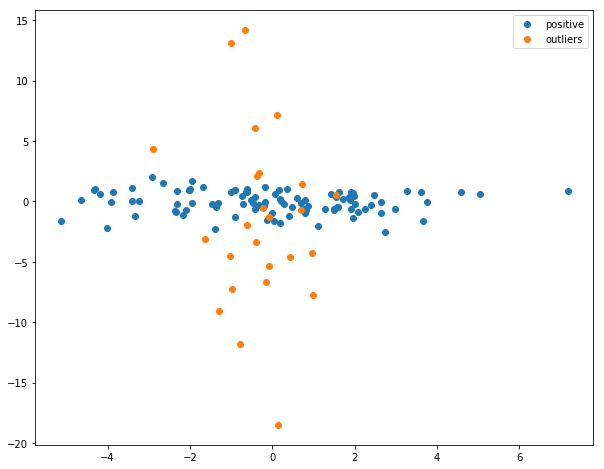

(-5.756744154612611, 7.8036108157672786)
(-20.147120634984688, 15.859984429486094)


In [52]:
# 构建协方差矩阵
gen_cov = np.eye(n_features)
gen_cov[0,0] = 2
# 生成按上面协方差矩阵分布的数据
X = np.random.randn(n_samples, n_features).dot(gen_cov)

# 离群点与正样本点服从不同的高斯分布
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1,n_features),np.arange(1,n_features)] = 7.
X[-n_outliers:] = np.random.randn(n_outliers, n_features).dot(outliers_cov)
#展示数据
fig = plt.figure(figsize=(10,8))
plt.scatter(X[:-n_outliers][:,0], X[:-n_outliers][:,1], label='positive')
plt.scatter(X[-n_outliers:][:,0], X[-n_outliers:][:,1], label='outliers')
xlim = plt.xlim()
ylim = plt.ylim()
plt.legend()
plt.show()
print(xlim)
print(ylim)


两个模型拟合数据

In [37]:
# fit a Minimum Covariance Determinant (MCD) robust estimator to data
robust_cov = MinCovDet().fit(X)

# compare estimators learnt from the full data set with true parameters
emp_cov = EmpiricalCovariance().fit(X)

画等高线

In [63]:
# 点数据
fig = plt.figure(figsize=(10,8))
inlier_plot = plt.scatter(X[:-n_outliers][:,0], X[:-n_outliers][:,1], c='b')
outlier_plot = plt.scatter(X[-n_outliers:][:,0], X[-n_outliers:][:,1], c='r')

xx,yy = np.meshgrid(np.linspace(xlim[0],xlim[1],100),np.linspace(ylim[0],ylim[1],100))
zz = np.c_[xx.ravel(),yy.ravel()]
print(zz.shape)

(10000, 2)


(10000,)
(100, 100)


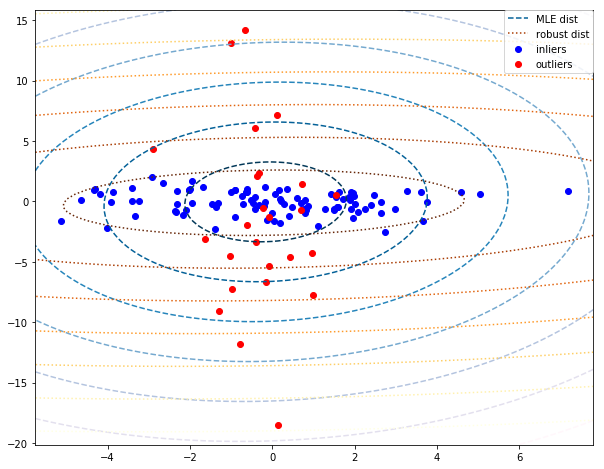

In [64]:
#最大似然协方差估计
mahal_emp_cov = emp_cov.mahalanobis(zz)
print(mahal_emp_cov.shape)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
print(mahal_emp_cov.shape)
emp_cov_contour = plt.contour(xx, yy, np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.PuBu_r,
                                  linestyles='dashed')

# 文件协方差估计
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = plt.contour(xx, yy, np.sqrt(mahal_robust_cov),
                                 cmap=plt.cm.YlOrBr_r, linestyles='dotted')
plt.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
                inlier_plot, outlier_plot],
          ['MLE dist', 'robust dist', 'inliers', 'outliers'],
          loc="upper right", borderaxespad=0)
plt.show()

# [孤立森林异常检测](http://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

In [2]:
rng = np.random.RandomState(42)

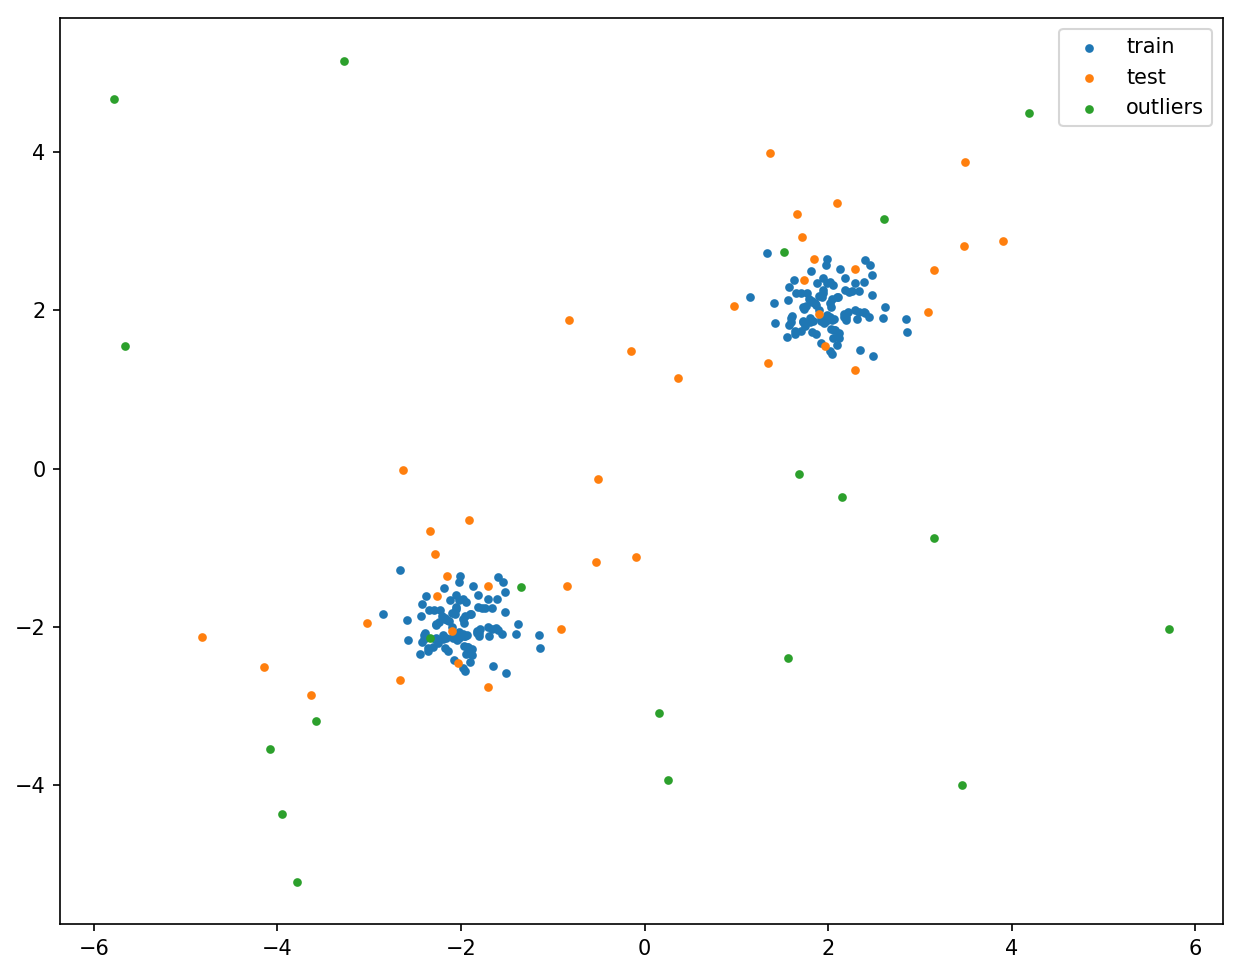

(-6.3660001740984375, 6.300646231989026)
(-5.755153598145256, 5.684532043809259)


In [44]:
# 生成数据
X = 0.3 * rng.randn(100,2)
X_train = np.r_[X+2, X-2]
X = 0.3 * rng.randn(20,2).dot(np.array([[3,0],[0,3]]))
X_test = np.r_[X+2,X-2]
X_outliers = rng.uniform(low=-6, high=6, size=(20,2))
plt.figure(figsize=(10,8),dpi=150)
plt.scatter(X_train[:,0], X_train[:,1], label='train',s=10)
plt.scatter(X_test[:,0], X_test[:,1], label='test',s=10)
plt.scatter(X_outliers[:,0], X_outliers[:,1], label='outliers',s=10)
xlim = plt.xlim()
ylim = plt.ylim()
plt.legend()
plt.show()
print(xlim)
print(ylim)

(50, 50)
(2500,)
(50, 50)


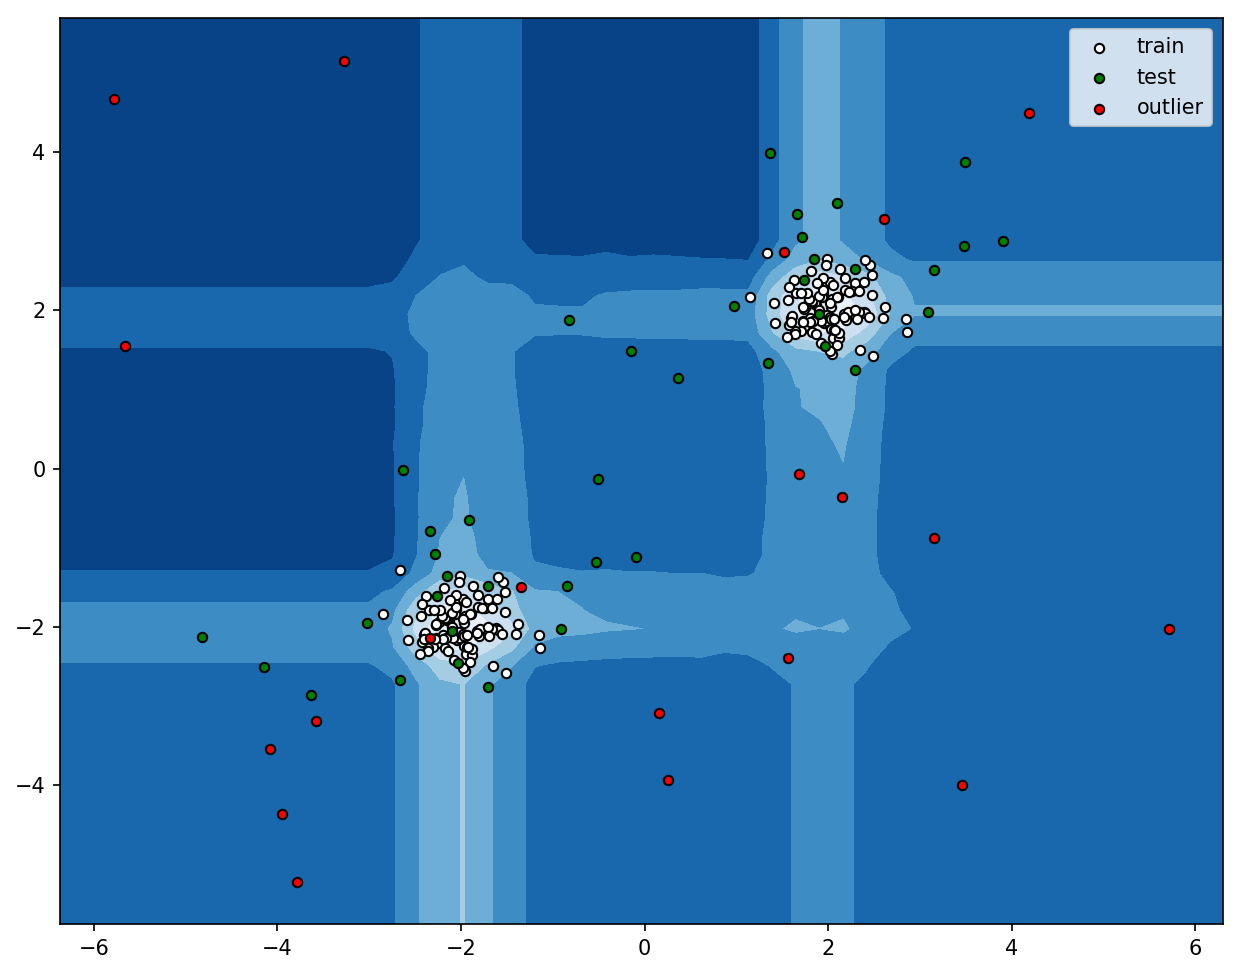

In [45]:
clf = IsolationForest(max_samples=200, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

xx,yy = np.meshgrid(np.linspace(xlim[0],xlim[1],50),np.linspace(ylim[0],ylim[1],50))
print(xx.shape)
Z = clf.decision_function(np.c_[xx.ravel(),yy.ravel()])
print(Z.shape)
Z = Z.reshape(xx.shape)
print(Z.shape)

plt.figure(figsize=(10,8),dpi=150)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r,)
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',label='train',s=20,
                 edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',label='test',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',label='outlier',
                s=20, edgecolor='k')
plt.legend()
plt.show()

# [集中异常值检测算法比较](http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html#sphx-glr-auto-examples-covariance-plot-outlier-detection-py)

样本中异常值数量已知时，此示例说明三种不同的执行新颖性和离群点检测的方法：